### 컬럼 설명

1. ID : 집을 구분하는 번호
2. date : 집을 구매한 날짜
3. price : 타겟 변수인 집의 가격
4. bedrooms : 침실의 수
5. bathrooms : 침실당 화장실 개수
6. sqft_living : 주거 공간의 평방 피트
7. sqft_lot : 부지의 평방 피트
8. floors : 집의 층수
9. waterfront : 집의 전방에 강이 흐르는지 유무 (a.k.a. 리버뷰)
10. view : 집이 얼마나 좋아 보이는지의 정도
11. condition : 집의 전반적인 상태
12. grade : King County grading 시스템 기준으로 매긴 집의 등급
13. sqft_above : 지하실을 제외한 평방 피트
14. sqft_basement : 지하실의 평방 피트
15. yr_built : 집을 지은 년도
16. yr_renovated : 집을 재건축한 년도
17. zipcode : 우편번호
18. lat : 위도
19. long : 경도
20. sqft_living15 : 근처 15 가구의 주거 공간, 평방 피트
21. sqft_lot15 : 근처 15가구의 부지, 평방 피트

In [48]:
import warnings
warnings.filterwarnings("ignore")

import os
from os.path import join

import pandas as pd
import numpy as np
import scipy as sp

import missingno as msno

from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor, VotingRegressor
from sklearn.model_selection import KFold, cross_val_score, train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.cluster import KMeans

from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [3]:
def get_scores(models, train, y):
    df = {}

    for model in models:
        # 모델 이름 획득
        model_name = model.__class__.__name__

        # train, test 데이터셋 분리
        # random_state를 사용하여 고정하고 train과 test 셋의 비율은 8:2로 합니다.
        X_train, X_test, y_train, y_test = train_test_split(train, y, test_size=0.2, random_state=random_state)

        # 모델 학습
        model.fit(X_train, y_train)

        # 예측
        y_pred = model.predict(X_test)

        # 예측 결과의 rmse값 저장
        df[model_name] = rmse(y_test, y_pred)
        
        # data frame에 저장
        score_df = pd.DataFrame(df, index=['RMSE']).T.sort_values('RMSE', ascending=False)

    print(df)

In [4]:
def my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5):
    # GridSearchCV 모델로 초기화
    grid_model = GridSearchCV(model, param_grid=param_grid, scoring='neg_mean_squared_error', \
                              cv=5, verbose=verbose, n_jobs=n_jobs)
    
    # 모델 fitting
    grid_model.fit(train, y)

    # 결과값 저장
    params = grid_model.cv_results_['params']
    score = grid_model.cv_results_['mean_test_score']
    
    # 데이터 프레임 생성
    results = pd.DataFrame(params)
    results['score'] = score
    
    # RMSLE 값 계산 후 정렬
    results['RMSLE'] = np.sqrt(-1 * results['score'])
    results = results.sort_values('RMSLE')

    return results

In [5]:
def save_submission(model, train, y, test, model_name, rmsle=None):
    model.fit(train, y)
    prediction = model.predict(test)
    prediction = np.expm1(prediction)
    data_dir = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data'
    submission_path = join(data_dir, 'sample_submission.csv')
    submission = pd.read_csv(submission_path)
    submission['price'] = prediction
    submission_csv_path = '{}/submission_{}_RMSLE_{}.csv'.format(data_dir, model_name, rmsle)
    submission.to_csv(submission_csv_path, index=False)
    print('{} saved!'.format(submission_csv_path))

In [6]:
def rmse(y_test, y_pred):
    return np.sqrt(mean_squared_error(np.expm1(y_test), np.expm1(y_pred)))

In [7]:
# 데이터 가져오기

data_dir = './data'
train_data_path = join(data_dir, 'train.csv')
test_data_path = join(data_dir, 'test.csv')

train = pd.read_csv(train_data_path)
test = pd.read_csv(test_data_path)

In [8]:
train

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,20140627T000000,257500.0,3,2.25,1715,6819,2.0,0,0,...,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,20150115T000000,291850.0,3,1.50,1060,9711,1.0,0,0,...,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15030,15030,20141014T000000,610685.0,4,2.50,2520,6023,2.0,0,0,...,9,2520,0,2014,0,98056,47.5137,-122.167,2520,6023
15031,15031,20150326T000000,1007500.0,4,3.50,3510,7200,2.0,0,0,...,9,2600,910,2009,0,98136,47.5537,-122.398,2050,6200
15032,15032,20140521T000000,360000.0,3,2.50,1530,1131,3.0,0,0,...,8,1530,0,2009,0,98103,47.6993,-122.346,1530,1509
15033,15033,20150223T000000,400000.0,4,2.50,2310,5813,2.0,0,0,...,8,2310,0,2014,0,98146,47.5107,-122.362,1830,7200


In [9]:
test

,id,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,15035,20141209T000000,3,2.25,2570,7242,2.0,0,0,3,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
1,15036,20141209T000000,4,3.00,1960,5000,1.0,0,0,5,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
2,15037,20140512T000000,4,4.50,5420,101930,1.0,0,0,3,11,3890,1530,2001,0,98053,47.6561,-122.005,4760,101930
3,15038,20150415T000000,3,1.00,1780,7470,1.0,0,0,3,7,1050,730,1960,0,98146,47.5123,-122.337,1780,8113
4,15039,20150312T000000,3,2.50,1890,6560,2.0,0,0,3,7,1890,0,2003,0,98038,47.3684,-122.031,2390,7570
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6463,21498,20140626T000000,3,1.75,1500,11968,1.0,0,0,3,6,1500,0,2014,0,98010,47.3095,-122.002,1320,11303
6464,21499,20150126T000000,3,2.00,1490,1126,3.0,0,0,3,8,1490,0,2014,0,98144,47.5699,-122.288,1400,1230
6465,21500,20150219T000000,3,2.50,1310,1294,2.0,0,0,3,8,1180,130,2008,0,98116,47.5773,-122.409,1330,1265
6466,21501,20140623T000000,2,0.75,1020,1350,2.0,0,0,3,7,1020,0,2009,0,98144,47.5944,-122.299,1020,2007


In [10]:
# date 컴럼 정리
train['date'] = train['date'].apply(lambda i: i[:6]).astype(int)
test['date'] = test['date'].apply(lambda i: i[:6]).astype(int)

In [11]:
skew_columns = ['bedrooms', 'sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement', 'sqft_lot15', 'sqft_living15']

for c in skew_columns:
    train[c] = np.log1p(train[c].values)
    test[c] = np.log1p(test[c].values)

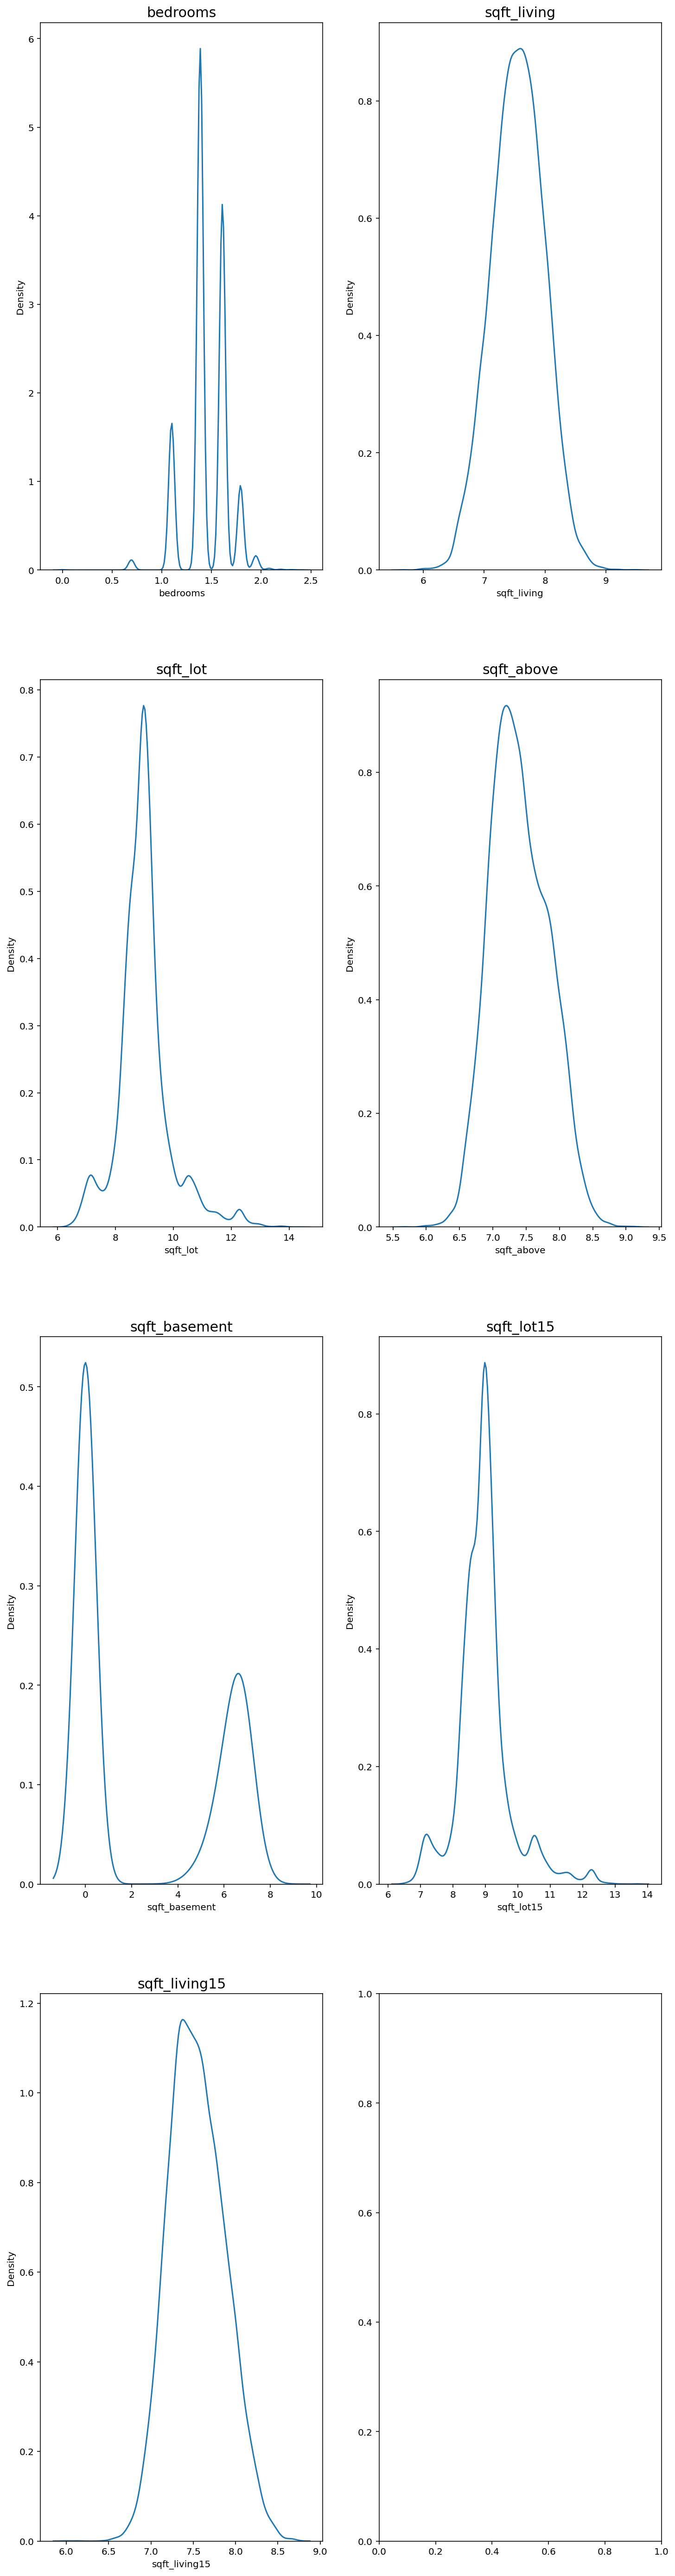

In [12]:
fig, ax = plt.subplots(4, 2, figsize=(12, 50))   # 가로스크롤 때문에 그래프 확인이 불편하다면 figsize의 x값을 조절해 보세요. 

temp = train[['bedrooms', 'sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement', 'sqft_lot15', 'sqft_living15']]

# id 변수(count==0인 경우)는 제외하고 분포를 확인합니다.
count = 0
columns = temp.columns
for row in range(4):
    for col in range(2):
        sns.kdeplot(data=temp[columns[count]], ax=ax[row][col])
        ax[row][col].set_title(columns[count], fontsize=15)
        count += 1
        if count == 7 :
            break

In [13]:
train['price'].describe()

count    1.503500e+04
mean     5.406827e+05
std      3.715247e+05
min      7.800000e+04
25%      3.220000e+05
50%      4.500000e+05
75%      6.450000e+05
max      7.700000e+06
Name: price, dtype: float64

<AxesSubplot:xlabel='price', ylabel='Density'>

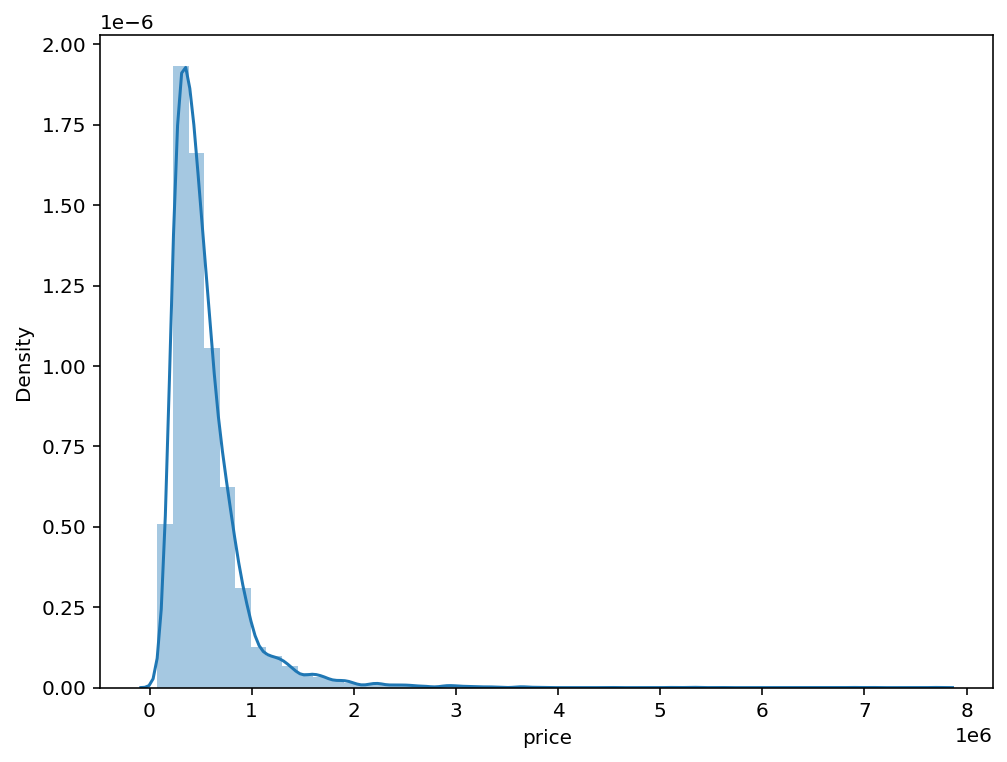

In [14]:
fig, ax = plt.subplots(figsize=(8, 6))
sns.distplot(train['price'])

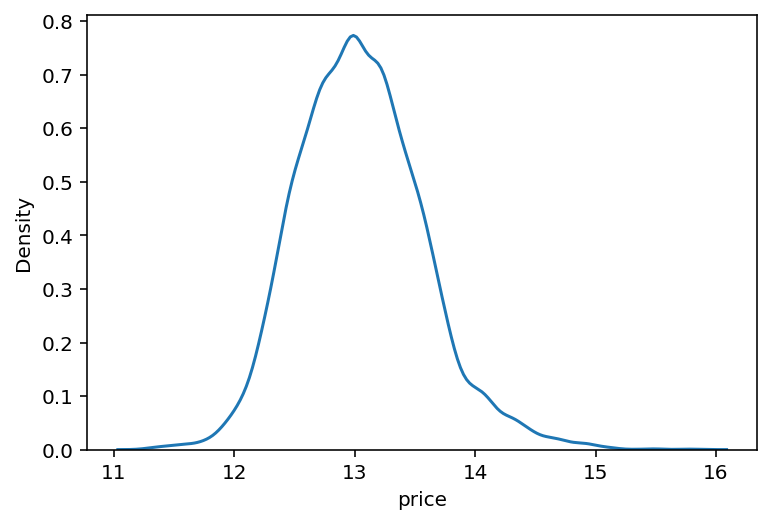

In [16]:
y_log_transformation = np.log1p(train['price'])

sns.kdeplot(y_log_transformation)
plt.show()

In [17]:
train['price'] = np.log1p(train['price'])

['price' 'grade' 'sqft_living' 'sqft_living15' 'sqft_above' 'bathrooms'
 'lat' 'bedrooms' 'floors' 'view']


<AxesSubplot:>

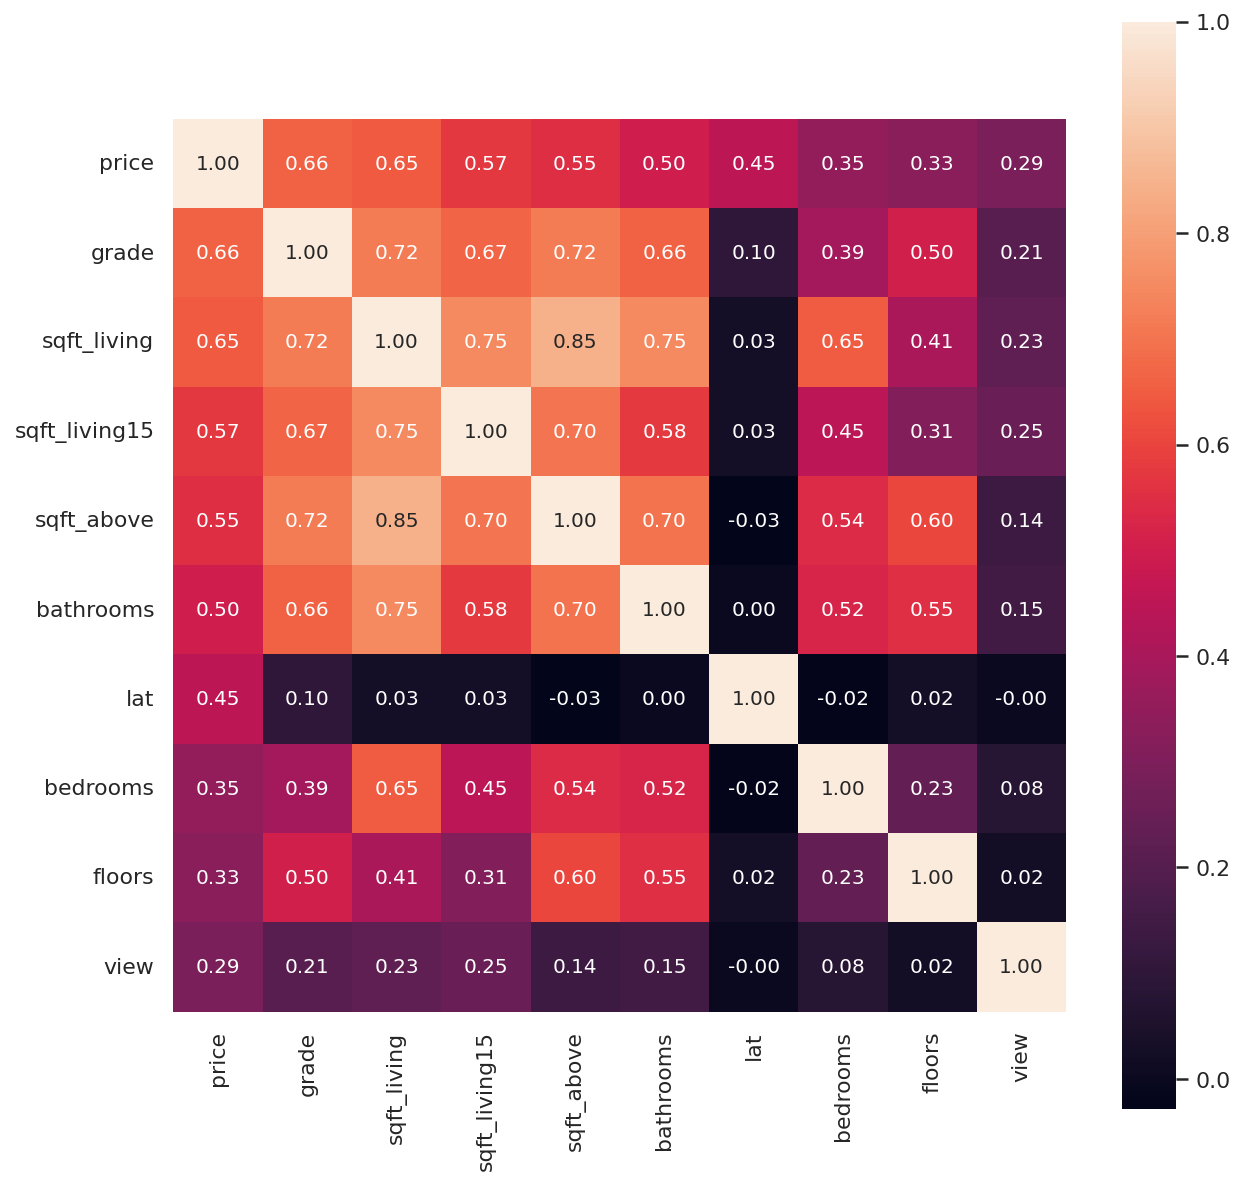

In [18]:
cor_abs = abs(train.corr(method='spearman')) 
cor_cols = cor_abs.nlargest(n=10, columns='price').index # price과 correlation이 높은 column 10개 뽑기(내림차순)
# spearman coefficient matrix
cor = np.array(sp.stats.spearmanr(train[cor_cols].values))[0] # 10 x 10
print(cor_cols.values)
plt.figure(figsize=(10,10))
sns.set(font_scale=1)
sns.heatmap(cor, fmt='.2f', annot=True, square=True , annot_kws={'size' : 10} ,xticklabels=cor_cols.values, yticklabels=cor_cols.values)

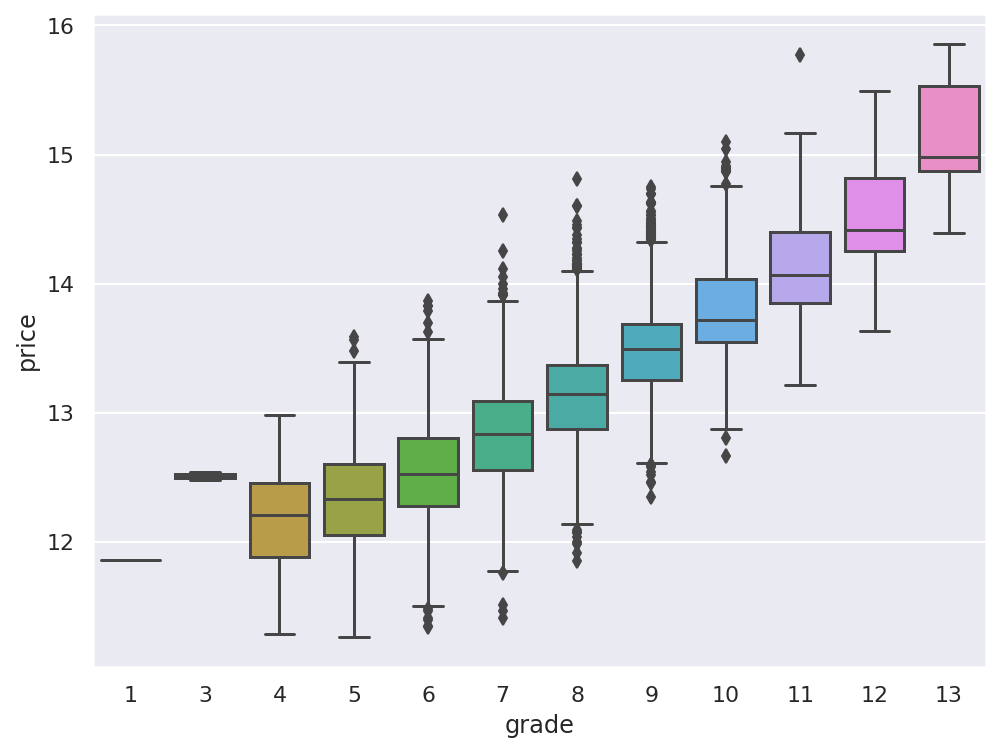

In [19]:
data = pd.concat([train['price'], train['grade']], axis=1)
fig, ax = plt.subplots(figsize=(8, 6))
fig = sns.boxplot(x='grade', y='price', data=data)

In [20]:
train.loc[(train['price'] > 12) & (train['grade'] == 3)]

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
2302,2302,201502,12.476104,0.693147,0.75,6.255750,9.471319,1.0,0,0,...,3,6.255750,0.0,1920,0,98022,47.2082,-121.995,7.201171,9.411974
4123,4123,201411,12.542548,0.693147,0.00,6.398595,10.106510,1.0,0,0,...,3,6.398595,0.0,1950,0,98045,47.5316,-121.749,6.898715,10.023490


In [21]:
train.loc[(train['price'] > 15.5) & (train['grade'] == 11)]

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
2775,2775,201406,15.77031,1.791759,4.5,9.214432,10.527445,2.0,1,2,...,11,8.946505,7.766841,1940,2001,98004,47.65,-122.214,8.276649,10.144471


In [22]:
train = train.loc[train['id'] != 2302]
train = train.loc[train['id'] != 4123]
train = train.loc[train['id'] != 2775]

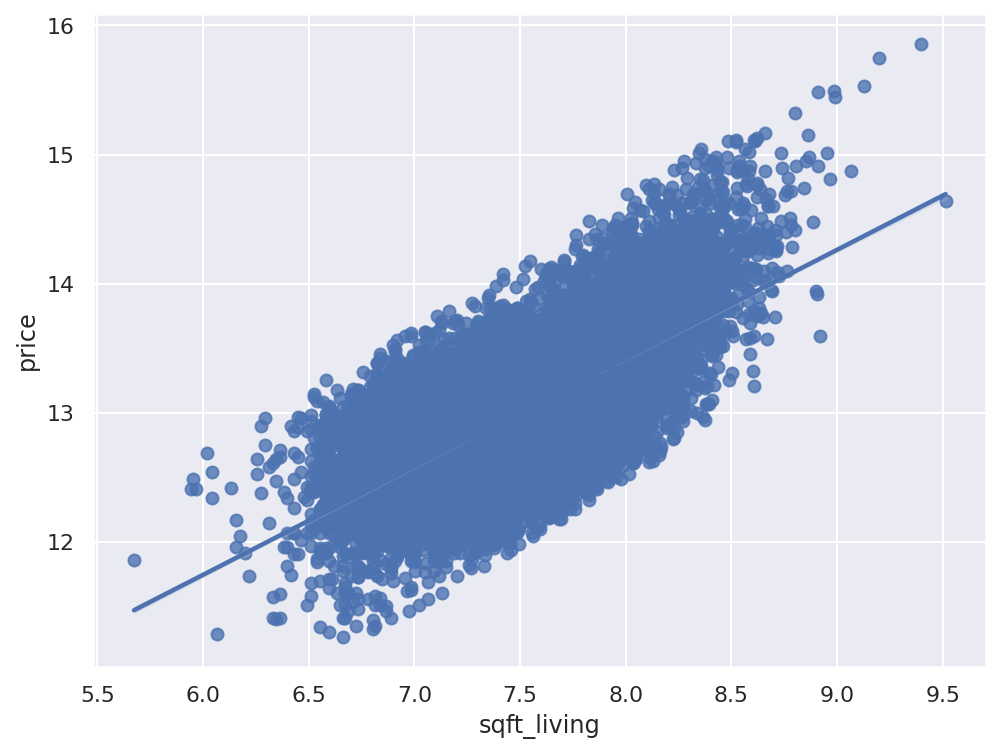

In [23]:
data = pd.concat([train['price'], train['sqft_living']], axis=1)
fig, ax = plt.subplots(figsize=(8, 6))
fig = sns.regplot(x='sqft_living', y='price', data=data)

In [24]:
train.loc[train['sqft_living'] > 9.5]

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
8912,8912,201405,14.639686,2.079442,8.0,9.513477,12.637053,3.0,0,4,...,12,9.149634,8.326275,1999,0,98053,47.6675,-121.986,8.48694,12.291337


In [25]:
train = train.loc[train['id'] != 8912]

In [26]:
# 변수 수정
for df in [train, test]:
    df['yr_renovated'] = df['yr_renovated'].apply(lambda x: np.nan if x == 0 else x)
    df['yr_renovated'] = df['yr_renovated'].fillna(df['yr_built'])

In [27]:
# 변수 생성
for df in [train, test]:
    # 방의 전체 갯수
    df['total_rooms'] = df['bedrooms'] + df['bathrooms']
    
    # 거실의 비율
    df['sqft_ratio'] = df['sqft_living'] / df['sqft_lot']
    df['sqft_total_size'] = df['sqft_above'] + df['sqft_basement']
    
    # 면적 대비 거실의 비율
    df['sqft_ratio_1'] = df['sqft_living'] / df['sqft_total_size']
    df['sqft_ratio15'] = df['sqft_living15'] / df['sqft_lot15']
    
    # 재건축 여부
    df['is_renovated'] = df['yr_renovated'] - df['yr_built']
    df['is_renovated'] = df['is_renovated'].apply(lambda x: 0 if x == 0 else 1)

In [28]:
# sqft당 가격 정보 변수 생성
train['per_price'] = train['price'] / train['sqft_total_size']
zipcode_price = train.groupby(['zipcode'])['per_price'].agg({'mean','var'}).reset_index()
train = pd.merge(train,zipcode_price,how='left',on='zipcode')
test = pd.merge(test,zipcode_price,how='left',on='zipcode')

In [29]:
# zipcode에 따른 가격정보인 zip_level 변수 생성
a = train[['zipcode', 'price']].groupby('zipcode').mean()
label = [j+1 for j in range(27)]
a['zip_level'] = pd.cut(a.price, bins=27, labels=label)
a = a.drop(['price'], axis=1)

train = train.merge(a, on='zipcode', how='left')
test = test.merge(a, on='zipcode', how='left')
train.zip_level = train.zip_level.astype(int)
test.zip_level = test.zip_level.astype(int)

0.727036944261851


<AxesSubplot:xlabel='zip_level', ylabel='price'>

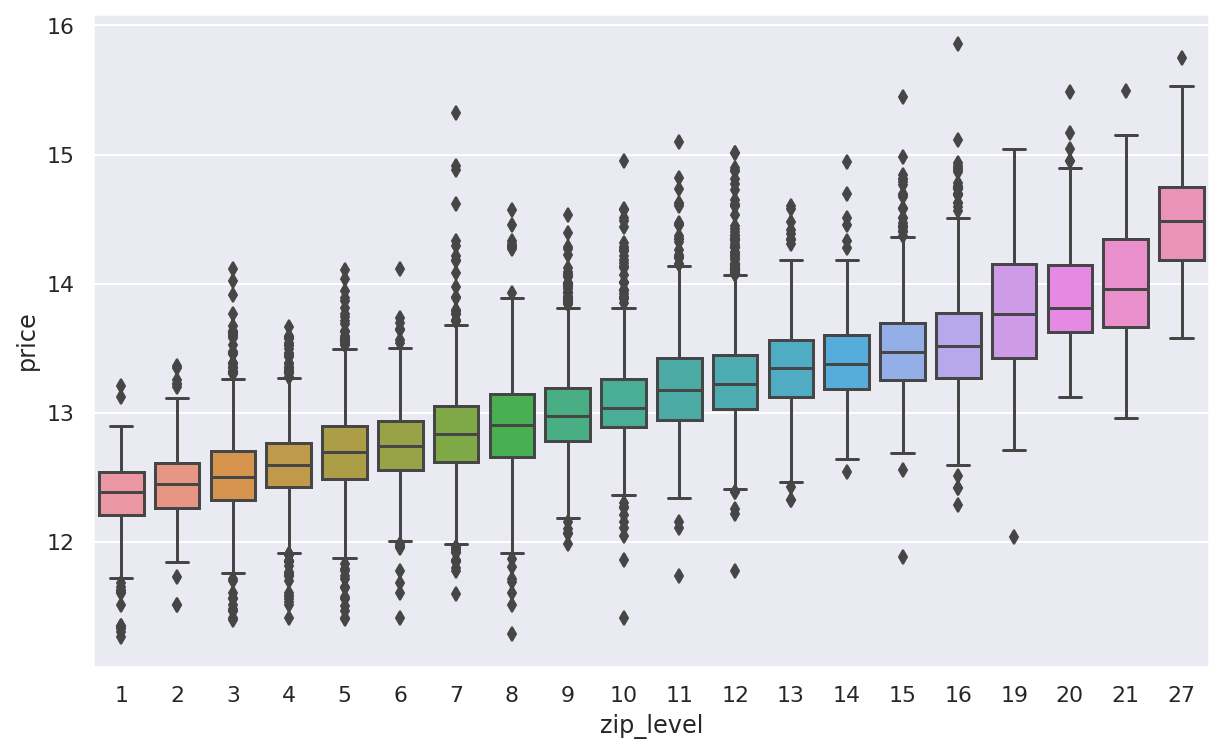

In [30]:
print(train.price.corr(train.zip_level))
fig = plt.figure(figsize=(10, 6))
sns.boxplot(train.zip_level, train.price)

In [31]:
# zip_mean_price를 Kmeans로 분류한 변수 생성
train['coord_cluster'] = None
test['coord_cluster'] = None

for i in train.zipcode.unique():
    df = train.loc[train.zipcode == i]
    coord = df[['lat','long']]
    num = (np.ceil(len(df) / 15)).astype(int)
    kmeans = KMeans(n_clusters=num, random_state=125).fit(coord)
    coord_cluster = kmeans.predict(coord)
    df['coord_cluster'] = coord_cluster
    df['coord_cluster'] = df['coord_cluster'].map(lambda x: 'c_' + str(x).rjust(2, '0'))
    train.loc[df.index, 'coord_cluster'] = df['coord_cluster']

    t_df = test.loc[test.zipcode == i]
    t_coord = t_df[['lat','long']]
    coord_cluster = kmeans.predict(t_coord)
    t_df['coord_cluster'] = coord_cluster
    t_df['coord_cluster'] = t_df['coord_cluster'].map(lambda x: 'c_' + str(x).rjust(2, '0'))
    test.loc[t_df.index, 'coord_cluster'] = t_df['coord_cluster']

train['test'] = train['zipcode'].astype(str) + train['coord_cluster']
test['test'] = test['zipcode'].astype(str) + test['coord_cluster']
k = train[['price','test']].groupby('test').mean()
k = k.rename(columns={'price' : 'mean_price'})

train = pd.merge(train, k, how='left', on='test')
test = pd.merge(test, k, how='left', on='test')
train = train.rename(columns={'price_x' : 'price', 'price_y' : 'mean_price'})

train = train.drop(['coord_cluster', 'test'], axis=1)
test = test.drop(['coord_cluster', 'test'], axis=1)

0.8354410466035043


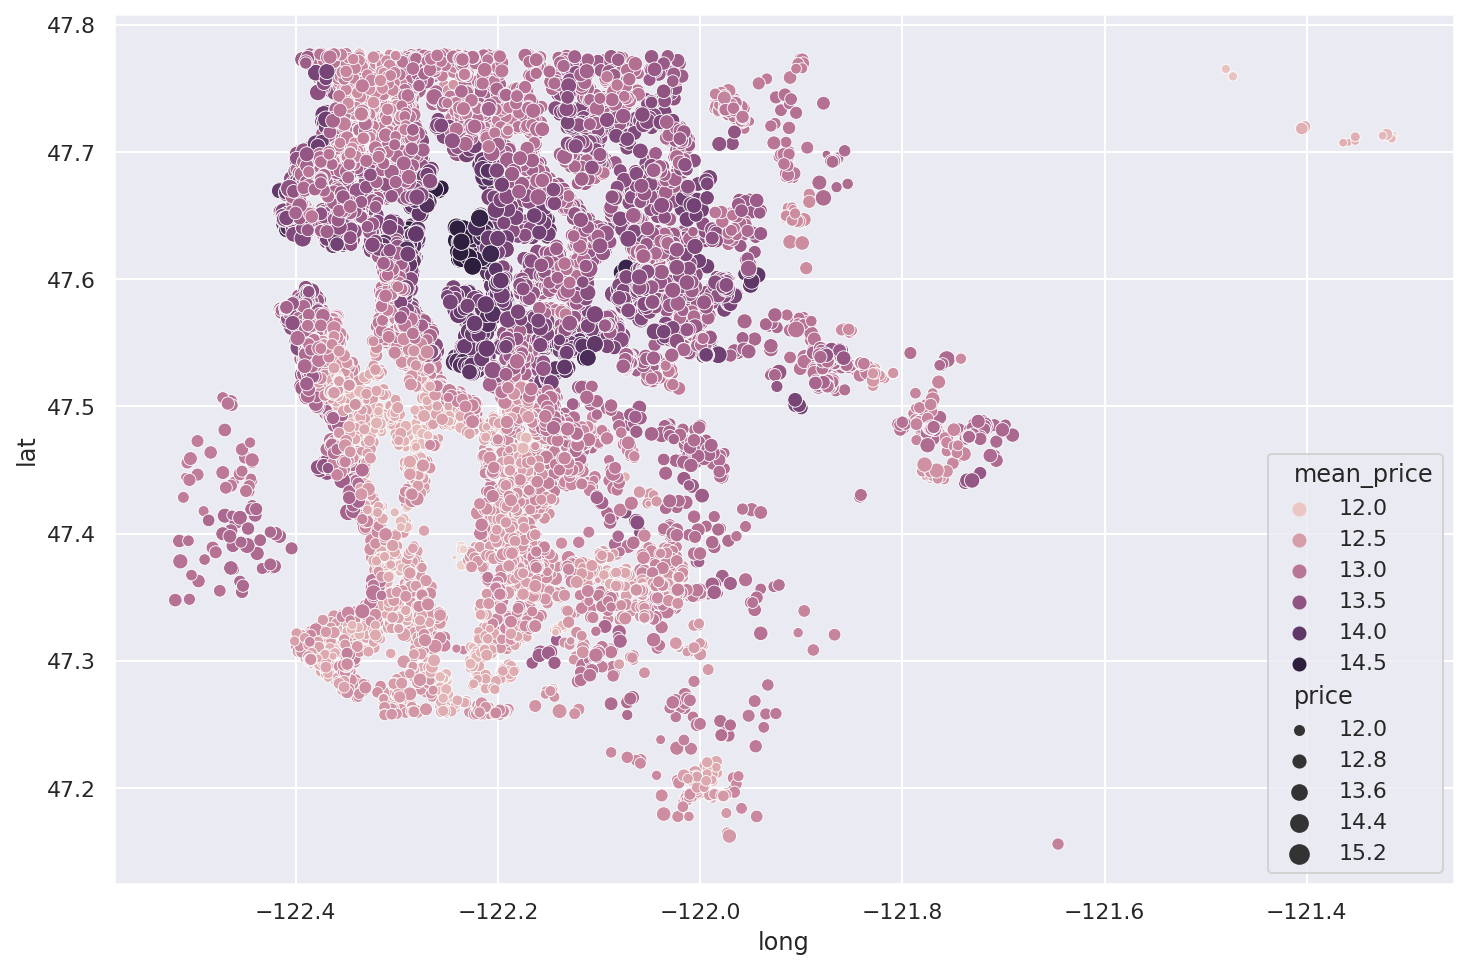

In [32]:
fig = plt.figure(figsize=(12,8))
sns.scatterplot(x='long',y='lat',hue='mean_price',size='price',sizes=(5,100), data=train)
print(train.price.corr(train.mean_price))

In [33]:
# grade + condition + view 를 합친 새로운 변수 생성
train['new_grade'] = train['grade'] + train['condition'] + train['view']
test['new_grade'] = test['grade'] + test['condition'] + test['view']

In [34]:
for df in [train, test]:
    df['zipcode_mean'] = df['mean'] * df['sqft_total_size']
    df['zipcode_var'] = df['var'] * df['sqft_total_size']
    del df['mean']; del df['var']

In [35]:
# target 분리
y = train['price']
del train['price']

In [36]:
sub_id = train['id']
del train['id']

In [37]:
del test['id']

In [38]:
# test에는 price정보가 없기 때문에 train에서 per_price col 삭제
del train['per_price']

In [39]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15031 entries, 0 to 15030
Data columns (total 30 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   date             15031 non-null  int64  
 1   bedrooms         15031 non-null  float64
 2   bathrooms        15031 non-null  float64
 3   sqft_living      15031 non-null  float64
 4   sqft_lot         15031 non-null  float64
 5   floors           15031 non-null  float64
 6   waterfront       15031 non-null  int64  
 7   view             15031 non-null  int64  
 8   condition        15031 non-null  int64  
 9   grade            15031 non-null  int64  
 10  sqft_above       15031 non-null  float64
 11  sqft_basement    15031 non-null  float64
 12  yr_built         15031 non-null  int64  
 13  yr_renovated     15031 non-null  float64
 14  zipcode          15031 non-null  int64  
 15  lat              15031 non-null  float64
 16  long             15031 non-null  float64
 17  sqft_living1

In [40]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6468 entries, 0 to 6467
Data columns (total 30 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   date             6468 non-null   int64  
 1   bedrooms         6468 non-null   float64
 2   bathrooms        6468 non-null   float64
 3   sqft_living      6468 non-null   float64
 4   sqft_lot         6468 non-null   float64
 5   floors           6468 non-null   float64
 6   waterfront       6468 non-null   int64  
 7   view             6468 non-null   int64  
 8   condition        6468 non-null   int64  
 9   grade            6468 non-null   int64  
 10  sqft_above       6468 non-null   float64
 11  sqft_basement    6468 non-null   float64
 12  yr_built         6468 non-null   int64  
 13  yr_renovated     6468 non-null   float64
 14  zipcode          6468 non-null   int64  
 15  lat              6468 non-null   float64
 16  long             6468 non-null   float64
 17  sqft_living15 

In [41]:
# random_state는 모델초기화나 데이터셋 구성에 사용되는 랜덤 시드값입니다. 
random_state=2020

In [42]:
# 탐색할 parameter 준비
param_grid = {
    'boosting' : ['goss'],
    'n_estimators': [1000, 1500],
    'max_depth': [5, 7, 9],
    'learning_rate': [0.015, 0.020]
}

In [43]:
model = LGBMRegressor(random_state=random_state)
my_GridSearch(model, train, y, param_grid, verbose=1, n_jobs=-1)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[LightGBM] [Warning] boosting is set=goss, boosting_type=gbdt will be ignored. Current value: boosting=goss


,boosting,learning_rate,max_depth,n_estimators,score,RMSLE
7,goss,0.020,5,1500,-0.023994,0.154901
6,goss,0.020,5,1000,-0.024076,0.155164
1,goss,0.015,5,1500,-0.024099,0.155238
3,goss,0.015,7,1500,-0.024137,0.155362
4,goss,0.015,9,1000,-0.024159,0.155431
5,goss,0.015,9,1500,-0.024160,0.155435
2,goss,0.015,7,1000,-0.024173,0.155475
8,goss,0.020,7,1000,-0.024192,0.155539
10,goss,0.020,9,1000,-0.024199,0.155560
9,goss,0.020,7,1500,-0.024278,0.155813


[LightGBM] [Warning] boosting is set=goss, boosting_type=gbdt will be ignored. Current value: boosting=goss
[LightGBM] [Warning] boosting is set=goss, boosting_type=gbdt will be ignored. Current value: boosting=goss
[LightGBM] [Warning] boosting is set=goss, boosting_type=gbdt will be ignored. Current value: boosting=goss
[LightGBM] [Warning] boosting is set=goss, boosting_type=gbdt will be ignored. Current value: boosting=goss
[LightGBM] [Warning] boosting is set=goss, boosting_type=gbdt will be ignored. Current value: boosting=goss
[LightGBM] [Warning] boosting is set=goss, boosting_type=gbdt will be ignored. Current value: boosting=goss
[LightGBM] [Warning] boosting is set=goss, boosting_type=gbdt will be ignored. Current value: boosting=goss
[LightGBM] [Warning] boosting is set=goss, boosting_type=gbdt will be ignored. Current value: boosting=goss
[LightGBM] [Warning] boosting is set=goss, boosting_type=gbdt will be ignored. Current value: boosting=goss
[LightGBM] [Warning] boostin

In [50]:
xgboost = XGBRegressor(learning_rate=0.024, max_depth=8, n_estimators=1000, random_state=random_state)
lightgbm0 = LGBMRegressor(boosting='goss', learning_rate=0.020, max_depth=5, n_estimators=1500, random_state=random_state)
lightgbm1 = LGBMRegressor(boosting='gbdt', learning_rate=0.020, max_depth=5, n_estimators=1500, random_state=random_state)
lightgbm2 = LGBMRegressor(boosting='goss', learning_rate=0.015, max_depth=5, n_estimators=1000, random_state=random_state)
lightgbm3 = LGBMRegressor(boosting='gbdt', learning_rate=0.015, max_depth=5, n_estimators=1000, random_state=random_state)
vtrgs = VotingRegressor(estimators=[('xgb', xgboost), ('lgbm0', lightgbm0), ('lgbm1', lightgbm1), ('lgbm2', lightgbm2), ('lgbm3', lightgbm3)])

In [51]:
get_scores([xgboost, lightgbm0, lightgbm1, lightgbm2, lightgbm3, ereg], train, y)

[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] boosting is set=goss, boosting_type=gbdt will be ignored. Current value: boosting=goss
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] boosting is set=goss, boosting_type=gbdt will be ignored. Current value: boosting=goss
{'XGBRegressor': 103950.30852724478, 'LGBMRegressor': 108486.29566812489, 'VotingRegressor': 104316.5813943149}


In [52]:
save_submission(ereg, train, y, test, "voting", 104316)

[LightGBM] [Warning] boosting is set=goss, boosting_type=gbdt will be ignored. Current value: boosting=goss
/aiffel/aiffel/kaggle_kakr_housing/data/submission_voting_RMSLE_104316.csv saved!


In [ ]:
# 회고


## 프로젝트 목표

> - 

## 성과 및 결과

> - 노드에서 제시한 월별 매출액 추세, 가장 인기있는 음식/음료, 가장 많이 팔린 입장권 종류에 대한 분석 및 시각화를 진행하였고 추가로 시간대 별 결제금액을 시각화하여 어느 시간때에 매출이 가장 좋은지 확인,
분류 별 결제금액을 시각화하여 어떤 상품이 제일 많이 팔리는지 확인하여 분석하였고 전략을 수립하였다. 

## 배운 점

> - 이번 노드에서 제시한 데이터들을 확인하며 데이터를 분석 것에 대하여 배울 수 있었고 이미 지난 노드들에서 배웠었지만 잊어버렸던 pandas, seaborn 라이브러리 사용법에 대하여 리마인드 할 수 있었다.  

## 개선할 점

> - 데이터를 가공하고 모델학습 후 예측하는 방법에 대해서 실력이 많이 부족한 것 같다.. 

## 결론

> - 데이터를 이용한 분석 및 시각화를 하고 이를 토대로 평가 및 전략을 세워보았다. 이를 진행하면서 아직 나에게 부족한 부분이 많다는 것을 느꼈고 부족한 부분을 채워나가기 위해서 학습을 열심히 해야겠다.